## Data exploration

In [1]:
# import libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import  MinMaxScaler
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dropout, LSTM, Dense
from tensorflow.keras.regularizers import l1
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.initializers import he_normal
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import datetime
from tensorflow.keras import backend
import requests
import bs4 as bs
import plotly.express as px
import plotly.graph_objs as go
import cufflinks as cf



### Download data
The following code is for illustrative purposes. The function`download_data` scrapes data from Yahoo Finance. The actual call of the function `download_data()` is hashed by default. You should load data directly from csv file by running subsequent cell.

In [2]:
def download_data():
    '''
    ***Code to download data from yfinance*** 
    Do not run unless you want to see the working logic. Instead, load data directly from the csv.
    '''
    resp = requests.get('http://en.wikipedia.org/wiki/List_of_S%26P_500_companies')
    soup = bs.BeautifulSoup(resp.text, 'lxml')
    table = soup.find('table', {'class': 'wikitable sortable'})
    tickers = []
    for row in table.findAll('tr')[1:]:
        ticker = row.findAll('td')[0].text
        tickers.append(ticker)
    tickers = [s.replace('\n', '') for s in tickers]
    
    
    # s&p500 components
    start = datetime.datetime(2000,1,1)
    end = datetime.datetime(2020,5,29)

    price_data = yf.download(tickers=tickers, start=start, end=end)["Adj Close"]
    volume_data = yf.download(tickers=tickers, start=start, end=end)["Volume"]
        
    
    price_data.columns = sorted(price_data.columns)
    volume_data.columns = sorted(volume_data.columns)
    price_data.to_csv("price_data.csv")
    volume_data.to_csv("volume_data.csv")
    
    

# download_data()   ### <-- do not run this ###

### Data load and cleaning
Data comprises S&P500 components' daily prices and volumes from January 2000 to May 2020. Companies with no data available on 02/01/2000 were removed. Forward fill was used to impute (rare) missings in the middle of the dataset. Daily log-returns and flows are easily computed from prices and volumes, respectively.

In [3]:
# load data
prices = pd.read_csv('price_data.csv', index_col = "Date", parse_dates=True, 
                     ).dropna(axis = 1, how = 'all').dropna(axis=0, how="all")

volumes = pd.read_csv('volume_data.csv', index_col = "Date", parse_dates=True, 
                    ).dropna(axis = 1, how = 'all').dropna(axis=0, how="all")

# download s&p 500 data to make benchmark later on
snp = yf.download("^GSPC", start=prices.index[0], end=prices.index[-1])[["Adj Close"]]

# drop columns of stocks that did not exist at starting date
frp, frv = prices.iloc[0,:], volumes.iloc[0,:] #first row
p_idx_existing = [i for i in range(len(frp.isna())) if not frp.isna()[i]]
v_idx_existing = [i for i in range(len(frv.isna())) if not frv.isna()[i]]
prices = prices.iloc[:, np.r_[p_idx_existing]]
volumes = volumes.iloc[:, np.r_[v_idx_existing]]

# forward-fill missing values
prices.fillna(axis = 0, method="ffill", inplace=True)
volumes.fillna(axis = 0, method="ffill", inplace=True)

# compute log-returns and flows (change in volumes)
returns   = np.log(prices/prices.shift(1)).dropna(axis=0, how="all")
flows = (volumes - volumes.shift(1)).dropna(axis=0, how="all")

# compute log-returns for s&p500
snp_ret = np.log(snp/snp.shift(1)).dropna(axis=0, how="all")

# check if any NaNs left
print("Any Nans left? {} for returns, {} for flows".format(returns.isna().any().any(), 
                                                           flows.isna().any().any()))

# 2 stocks have no flow data available, so we remove them
returns =  returns[flows.columns]

# rename columns
returns.columns = returns.columns + "_r"
flows.columns = flows.columns + "_flow"

#check shape
print("returns shape: {}, flows shape: {}".format(returns.shape, flows.shape))

[*********************100%***********************]  1 of 1 completed
Any Nans left? False for returns, False for flows
returns shape: (5132, 375), flows shape: (5132, 375)


As we can see, the dataset includes daily stock returns (and flows) for 375 different stocks observed over 5132 consecutive (trading) days.

### Feature engineering
We want to make rolling 1-day-ahead return forecasts using the entire crosssection of lagged returns, lagged volume flows, 20-day look-back volatilities and 5-day-, 20-day-,  and 250-day-lookback cumulative returns as predictors, inspired by Chinco, Clark-Joseph, Ye (2019). Their rational is that "cross-section of lagged returns contains a sparse collection of signals" that can be applied to make look-ahead predictions. We modify their intraday approach to a lower frequency environment, using daily returns. Moreover, we add the aforesaid additional features, taking a data-driven approach. The following cells define the appropriate functions to "engineer" the aforesaid features from the available ones:

In [4]:
# define functions for data engineering
# build dataset with n-lag returns for each feature
def lags_builder(dataset, n_lags):
    # function to add lags
    cache = []
    for i in range(n_lags):
        lag_df = dataset.shift(i+1)
        lag_df.columns = dataset.columns.map(lambda x : x+'_lag_'+str(i+1))
        cache.append(lag_df)
    dataset_with_lags = pd.concat(cache, axis=1)
    return dataset_with_lags

# build dataset with look-back volatility for each feature
def rolling_lag_volatility_builder(dataset, look_back_window):
    volatility_df = dataset.rolling(look_back_window).apply(lambda x: np.nanstd(x))
    old_col = list(volatility_df.columns)
    for i in range(len(old_col)):
        old_col[i] = old_col[i].replace("_r_lag_1",'_std_'+str(look_back_window))
    volatility_df.columns = old_col
    return volatility_df

# build dataset with look-back cumulative return for each feature
def rolling_lag_cumreturn_builder(dataset, look_back_window):
    cum_ret_df = dataset.rolling(look_back_window).apply(lambda x: np.nansum(x))
    old_col = list(cum_ret_df.columns)
    for i in range(len(old_col)):
        old_col[i] = old_col[i].replace("_r_lag_1",'_mom_'+str(look_back_window))
    cum_ret_df.columns = old_col
    return cum_ret_df

The following cell is for illustrative purposes and takes long to run, thus code is hashed by default. You can either un-hash and run it or load data that already includes engineered features by running subsequent cell. 

In [ ]:
'''
# clean data, generate interesting features. NB: ***do not run unless you want to see the working logic***
# generate 1-day lag returns, 1-day lag flows, 20-day look-back rolling volatility, 5-day, 20-day, 250-day look-back returns 

returns_1_lags  = lags_builder(returns, 1)
flows_1_lags    = lags_builder(flows, 1)
vols_20         = rolling_lag_volatility_builder(returns_1_lags, 20)
cum_returns_5   = rolling_lag_cumreturn_builder(returns_1_lags, 5)
cum_returns_20  = rolling_lag_cumreturn_builder(returns_1_lags, 20)
cum_returns_250 = rolling_lag_cumreturn_builder(returns_1_lags, 250)

# concatenate dataframe making stock returns in first 100 columns as dependent variables
data = pd.concat([returns, returns_1_lags, flows_1_lags, vols_20, cum_returns_5, 
                  cum_returns_20, cum_returns_250 ], axis = 1).iloc[250:,:]

pickle.dump(data, open("data_engineered.pkl", "wb"))
'''

In [6]:
# load data with engineered features using .pkl file
data = pickle.load(open("data_engineered.pkl", "rb" ))
y_columns = data.columns[:375]
x_columns = data.columns[375:]

In [7]:
# display targets, i.e., returns to be predicted
display(data[y_columns].head(3))

# display predictors 
display(data[x_columns].head(3))

,A_r,AAPL_r,ABC_r,ABMD_r,ABT_r,ADBE_r,ADI_r,ADM_r,ADP_r,ADSK_r,...,WST_r,WY_r,XEL_r,XLNX_r,XOM_r,XRAY_r,XRX_r,YUM_r,ZBRA_r,ZION_r
Date,,,,,,,,,,,,,,,,,,,,,
2000-12-29,-0.010221,0.004211,-0.041218,-0.040410,-0.001289,-0.057397,-0.053488,0.025318,-0.000986,0.016375,...,-0.017654,-0.024332,-0.002148,-0.051497,0.000720,-0.085679,-0.077961,-0.013171,-0.074163,0.006024
2001-01-02,-0.073406,0.000000,-0.011202,-0.074901,-0.006473,-0.218967,-0.085348,-0.025318,-0.019941,-0.047515,...,-0.002548,-0.012392,-0.026145,-0.064358,0.024850,-0.003200,0.102654,-0.032726,0.037953,-0.040864
2001-01-03,0.098210,0.096074,0.019828,0.090247,-0.022325,0.214885,0.148053,-0.043675,-0.021375,0.063678,...,0.040005,0.024632,-0.035959,0.166053,-0.044452,-0.052644,0.024097,0.055199,0.102258,0.032824


,A_r_lag_1,AAPL_r_lag_1,ABC_r_lag_1,ABMD_r_lag_1,ABT_r_lag_1,ADBE_r_lag_1,ADI_r_lag_1,ADM_r_lag_1,ADP_r_lag_1,ADSK_r_lag_1,...,WST_mom_250,WY_mom_250,XEL_mom_250,XLNX_mom_250,XOM_mom_250,XRAY_mom_250,XRX_mom_250,YUM_mom_250,ZBRA_mom_250,ZION_mom_250
Date,,,,,,,,,,,,,,,,,,,,,
2000-12-29,-0.011236,0.000000,0.015560,-0.024451,-0.001288,-0.060982,-0.028524,0.021599,0.008915,0.068319,...,-0.162042,-0.263985,0.488924,0.038038,0.146496,0.603236,-1.563024,-0.109651,-0.248148,0.132055
2001-01-02,-0.010221,0.004211,-0.041218,-0.040410,-0.001289,-0.057397,-0.053488,0.025318,-0.000986,0.016375,...,-0.189973,-0.250027,0.464011,0.009530,0.166556,0.517557,-1.593357,-0.102516,-0.307777,0.187714
2001-01-03,-0.073406,0.000000,-0.011202,-0.074901,-0.006473,-0.218967,-0.085348,-0.025318,-0.019941,-0.047515,...,-0.188423,-0.314037,0.400007,-0.032696,0.138324,0.497217,-1.540912,-0.140358,-0.288788,0.148034


### Data processing
Train / Validation / Test split of data is 70/10/20. Moreover, data is scaled to values between $[-1,1]$. Finally, predictor matrices for train, test and validation sets are reshaped to account for input requirements for recurrent neural networks.

In [8]:
split1, split2 = round(0.7*len(data)), round(0.8*len(data))
train, valid, test = data.iloc[:split1], data.iloc[split1:split2], data.iloc[split2:]
train_x, valid_x, test_x = train[x_columns], valid[x_columns], test[x_columns]
train_y_all, valid_y_all, test_y_all = np.array(train[y_columns]), np.array(valid[y_columns]), np.array(test[y_columns])

scaler = MinMaxScaler(feature_range=(-1, 1))
train_x = scaler.fit_transform(train_x) 
valid_x = scaler.transform(valid_x)
test_x  = scaler.transform(test_x)


# reshape input to be 3D [samples, timesteps, features]
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
valid_x = valid_x.reshape((valid_x.shape[0], 1, valid_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))
print(train_x.shape, valid.shape, test_x.shape)


(3417, 1, 2250) (489, 2625) (976, 1, 2250)


## Model 

### Model design
We have 375 different targets (stock return time series) we want to predict separately, by using the same predictors (the whole cross-section of the aforesaid variables for each point in time). We would like to use the same model architecture for each stock, but the trained models will be estimated separately (375 different estimations). As previously mentioned, the objective is to predict the one-day-ahead return for each of the 375 stocks. The recurrent neural network consists in a two-layer LSTM with 50 and 100 units, respectively. Each stock's model is trained separately, and early stopping is adopted to avoid overfitting. More specifically, $R^2$ metric is evaluated for the decision of the optimal stopping point. According to Gu et al. (2020), "predicting future excess stock returns with historical averages typically underperforms a naive forecast of zero by a large margin". Thus, the denominator of our $R^2$ metric is not "demeaned". The various hyperparameters are empirically chosen after some manual trial end error approach on a sub-sample of stocks. Even though a Grid / Random Search would be more effective, it was out of the scope of the exercise.  

In [9]:
# define modified r-squared
def r2(y_true, y_pred):
    SS_res =  backend.sum(backend.square( y_true-y_pred ))
    SS_tot = backend.sum(backend.square( y_true))           
    return ( 1 - SS_res/SS_tot)


# define model
def lstm_model(train_x, train_y, valid_x, valid_y):
    
    # define early stopping
    earlystopper = tf.keras.callbacks.EarlyStopping(monitor='val_r2', patience=50, mode="max", 
                                                restore_best_weights=True)
    # design network
    model = tf.keras.Sequential()
    model.add(LSTM(50, activation="relu", input_shape=(None, train_x.shape[2]),
                    return_sequences=True, dropout=0.4))
    model.add(LSTM(100, activation="relu", return_sequences=False,))                     
    model.add(Dense(1))
    
    # model compile & fit
    model.compile(loss='mse',  optimizer=RMSprop(lr=0.0005), metrics=[r2])
    history = model.fit(train_x, train_y, epochs=1000, batch_size=256, validation_data=(valid_x, valid_y), 
                        verbose=2, callbacks=[earlystopper], shuffle=False)
    
    return model

### Model training
The following cell estimates the model parameters for each stock.  It takes long to run, thus code is hashed by default. Use  predictions coming from already-trained models instead.

In [ ]:
'''

# estimate model for each stock
# set seed for reproducibility
np.random.seed(1)
tf.random.set_seed(2)

# initialize empty dataframe for predictions
test_y_pred = pd.DataFrame()

# estimate model for each stock
for train_y, valid_y, stock_name in tqdm(zip(train_y_all.transpose(), valid_y_all.transpose(), y_columns),
                                         total=len(y_columns)):
    
    model = lstm_model(train_x, train_y, valid_x, valid_y)
    
    # make predictions on testset and store them in dataframe
    y_pred = model.predict(test_x)
    y_pred = pd.DataFrame(y_pred, columns = [stock_name], index = test[x_columns].index)
    test_y_pred = pd.concat([test_y_pred, y_pred], axis=1)
    

pickle.dump(test_y_pred, open("test_y_pred.pkl", "wb"))
pickle.dump(dict_r2, open("dict_r2.pkl", "wb"))

'''

In [10]:
# load predicted returns for each stock from .pkl file
test_y_pred = pickle.load(open("test_y_pred.pkl", "rb" ))
test_y_all = test[y_columns]
display(test_y_pred.head(3))
display(test_y_all.head(3))


,A_r,AAPL_r,ABC_r,ABMD_r,ABT_r,ADBE_r,ADI_r,ADM_r,ADP_r,ADSK_r,...,WST_r,WY_r,XEL_r,XLNX_r,XOM_r,XRAY_r,XRX_r,YUM_r,ZBRA_r,ZION_r
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-13,0.001119,0.002010,-0.000103,0.000374,-0.000366,0.000094,0.000136,0.000213,-0.000459,-0.000242,...,0.000673,-0.000414,0.000431,-0.001348,-0.001022,0.000117,0.000143,0.000928,0.001959,-0.000191
2016-07-14,0.001014,0.002079,0.000881,0.003736,-0.000353,0.000452,0.000289,-0.001765,-0.000296,-0.000531,...,0.002122,0.000283,0.000907,-0.001847,-0.000206,0.000348,-0.000085,0.001122,0.001229,0.001077
2016-07-15,0.001010,0.002068,0.000473,0.002761,0.000255,0.000319,0.000201,-0.000716,-0.000132,-0.000314,...,0.001077,-0.000533,0.000510,-0.001710,-0.001133,0.000176,-0.000523,0.000947,0.000798,0.000548


,A_r,AAPL_r,ABC_r,ABMD_r,ABT_r,ADBE_r,ADI_r,ADM_r,ADP_r,ADSK_r,...,WST_r,WY_r,XEL_r,XLNX_r,XOM_r,XRAY_r,XRX_r,YUM_r,ZBRA_r,ZION_r
Date,,,,,,,,,,,,,,,,,,,,,
2016-07-13,-0.002582,-0.005662,0.008870,-0.002125,-0.005702,-0.002053,0.008944,-0.004399,0.003475,-0.008928,...,-0.008307,0.003760,0.010292,0.002944,-0.000737,-0.002379,-0.006224,0.001749,-0.010113,-0.002345
2016-07-14,0.008368,0.019627,0.011938,0.002295,0.007359,0.003692,0.008366,0.008778,0.000735,0.022430,...,0.004737,0.002187,-0.007766,0.004609,0.000737,0.004436,0.004154,0.029081,0.003855,0.018228
2016-07-15,-0.002782,-0.000101,-0.004665,-0.005449,-0.004266,0.001330,0.002163,0.010752,-0.001577,-0.003100,...,-0.006407,-0.000312,0.003205,0.001254,0.001789,-0.004754,0.000000,-0.008876,0.012278,-0.000384


### Assessment of out-of-sample performance
After we collected the matrix of predictions, we apply a simple long/short equally-weighted trading strategy. Specifically, we  buy (sell) top-(bottom-)5% stocks ranked by predicted return and adjust portfolio daily. We use Sharpe Ratio and maximum drawdown as performance metrics for both the strategy based on neural network predictions and a passive strategy holding S&P500 index over the period.

In [11]:
# utility functions
# define signal to buy (sell) top (bottom) 5% stocks ranked by predicted return
def top_bottom_signal(series, percentile=0.05):
    n_avail_stocks = max(series.dropna())
    right = int(n_avail_stocks*(1-percentile))
    left = int(n_avail_stocks*percentile)
    return np.where(series<=left, -1, np.where(series>=right, 1, 0))

def maximumDrawdown(cum_rets):
    mdd = 0
    cum_rets = np.array(cum_rets)
    peak = cum_rets[0]
    for ret in cum_rets:
        if ret > peak: peak = ret
        dd = (peak - ret) / peak
        if dd > mdd: mdd = dd
    return float(mdd)

def sharpeRatio(returns, rf_rates):
    return float(((np.mean(returns)-np.mean(np.array(tbill)))/np.std(returns)) * 252**0.5)

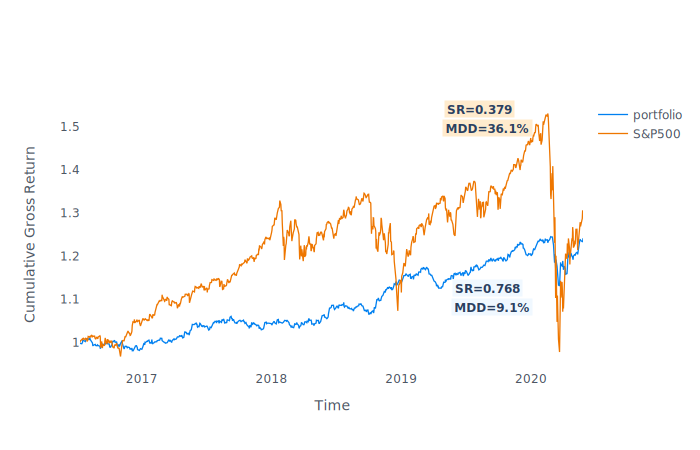

In [18]:
# filter s&p500 returns on test set dates
snp_ret_test = snp_ret.loc[snp_ret.index.intersection(test_y_pred.index)]
snp_cum_ret_test = np.cumprod(snp_ret_test+1) 
snp_cum_ret_test.columns=["S&P500"]

# 3Mtbill (risk-free rate) load
date_parser = lambda x: pd.datetime.strptime(x, '%d/%m/%Y')
tbill = pd.read_csv("3m_tbill_daily.csv", index_col='date', date_parser=date_parser)
tbill = tbill.applymap(lambda x: np.nan if x=="." else float(x))
tbill.fillna(axis = 0, method="ffill", inplace=True)
tbill = tbill.applymap(lambda x: (x/100 + 1)**(1/252) -1)
tbill = tbill.loc[snp_ret_test.index]

# rank stocks by their predicted 1-day ahead return
ranks = test_y_pred.rank(axis=1)

# build top-(bottom-)5% long(short) positions based on ranks
positions = ranks.apply(top_bottom_signal, axis=1, result_type="expand")
n_stock_traded = positions.applymap(lambda x: abs(x)).sum(axis=1)

# build portfolio returns based on realized returns and positions taken
portf = np.multiply(positions, test_y_all)
portf_rets = portf.sum(axis=1)/n_stock_traded 
portf_cum_rets = pd.DataFrame(np.cumprod(portf_rets+1), columns=["portfolio"])

results = pd.concat([portf_cum_rets, snp_cum_ret_test], axis=1)

# compute Sharpe Ratio and maximum drawdown for both strategies
annual_sharpe_portfolio = sharpeRatio(portf_rets, tbill)
annual_sharpe_sp        = sharpeRatio(snp_ret_test, tbill)
mdd_portfolio = maximumDrawdown(portf_cum_rets)
mdd_snp       = maximumDrawdown(snp_cum_ret_test)



# plot
fig = results.iplot(colorscale = "polar", xTitle = "Time", yTitle = "Cumulative Gross Return", 
                        theme="white", asFigure=True)

fig.update_layout(
    xaxis = {'showgrid': False}, yaxis = {'showgrid': False},
    
    annotations=[
        dict(x=0.88, y=0.27, showarrow=False, 
             text="<b>SR={:1.3f}<b>".format(annual_sharpe_portfolio), xref="paper", yref="paper", bgcolor="aliceblue"),
                 
        dict(x=0.9, y=0.2, showarrow=False, 
             text="<b>MDD={:.1%}<b>".format(mdd_portfolio), xref="paper", yref="paper", bgcolor="aliceblue"),
        
        dict(x=0.865, y=1, showarrow=False, 
             text="<b>SR={:1.3f}<b>".format(annual_sharpe_sp), xref="paper", yref="paper", bgcolor="blanchedalmond"),
        
        dict(x=0.9, y=0.93, showarrow=False, 
                      text="<b>MDD={:.1%}<b>".format(mdd_snp), xref="paper", yref="paper", bgcolor="blanchedalmond"),
                ]
    
                 )     

fig.write_image("S&P_vs_portfolio.png", format="png")
fig.show("svg")

#### Comment to performance metrics
The portfolio is clearly lagging S&P 500 over the 4-year period considered, excluding the recent crisis. However, it is way less volatile. The strategy provides a solid Sharpe Ratio of 0.768 (vs.0.379 for S&P500), with a maximum drawdown of 9.1% during the recent Covid crisis, much lower if compared to the huge drawdown in S&P500 (-36.1% between 20th February 2020 and 23rd March 2020). 

## Conclusion
The study is by no mean exhaustive and does not constitute trading advice. To be more realistic, transaction costs should be taken into account. Moreover, feasiblity of the trades in proximity of market closing time should be assessed. In addition,  a more structured hyperparameter tuning might deliver better results. Nevertheless, We believe it is an interesting starting point for the exploration of more sophisticated trading strategies and the possible application in other asset classes. 

## References
Chinco, A., Clark-Joseph, A. D., & Ye, M. (2019). Sparse Signals in the Cross-Section of Returns. _Journal of Finance_. https://doi.org/10.1111/jofi.12733

Gu, S., Kelly, B. & Xiu, D. (2020) Empirical Asset Pricing via Machine Learning. _The Review of Financial Studies_. 33 (5), 2223-2273.





